# Multi Layer Perceptron (MLP) の実装

# 目次

1. [全体像](#pipeline)
1. [目標](#goal)
- [下準備](#prepare)
- [活性化関数](#activate)
- [線形層](#linear)
- [多層パーセプトロン](#mlp)
- [学習](#train)

# 1. 全体像<a class="anchor" id="pipeline"></a>
- 変数のあとの括弧は，行列の形状 (numpy.ndarrayのshape) を表す．
- Nはバッチサイズ

※ バッチ処理とは……画像を1枚ずつ処理するのではなく，複数枚まとめて処理すること．画像1枚は，28×28のサイズから(784, )の形状をもつ1次元配列になるようにリサイズされているが，これをN枚まとめて(N, 784)の2次元配列として扱う．N枚まとめて行列演算を実行することで，1枚ずつ処理するより高速に処理できるようになる．

<img src="https://drive.google.com/uc?export=download&id=1q-o-iqPQ5gdDajty-sFNEJKYWRRXicW5">

## 2. 目標<a class="anchor" id="goal"></a>
- 多層 (例では3層) のニューラルネットワークを構築する．
- まず**活性化関数**をそれぞれ実装し，次に**線形層**の実装を行い，最後にそれらをまとめて**多層パーセプトロン**の実装を行う．
- 最終的には，下のように各レイヤーの入出力のユニット数と活性化関数を指定するだけでモデルが構築できるようにする．
- 例：3層・隠れ層のユニット数が1000．活性化関数はReLUを用いる場合
```python
model = MLP([Linear(784, 1000, ReLU),
                        Linear(1000, 1000, ReLU),
                        Linear(1000, 10, Softmax)])
```
- こうすると，4層以上への拡張や，活性化関数の変更などがしやすい

## 3. 下準備<a class="anchor" id="prepare"></a>

### ライブラリのインポート

- matplotlib: 図やグラフの描画など．
- numpy: 行列演算など
- sklearn: scikit-learn．様々な機械学習のモデルが利用できるが，今回はMNISTのデータをダウンロードするのに用いる．

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from __future__ import unicode_literals
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

In [2]:
from google.colab import drive # driveを接続
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# drive中の課題ファイルのあるディレクトリに移動
%cd /content/gdrive/My Drive/先端人工知能論Ⅰ/handson20210511/

from test_mlp import *  # テスト用

/content/gdrive/My Drive/先端人工知能論Ⅰ/handson20210511


### MNISTデータの読み込み

- データをダウンロードする．一度ダウンロードすると，その後はデータを参照して読み込んでくれるので，毎回ダウンロードしなくても良くなる．
- X：画像データ(各画像784次元）， Y：ラベル
- mnistのデータは，0~255のint型で表されているが，これを**255で割って正規化**する．

In [4]:
X, Y = fetch_openml('mnist_784', version=1, data_home="./data/", return_X_y=True)

In [5]:
X = X / 255.
Y = Y.astype("int")

### データセットの可視化

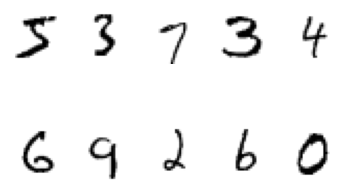

In [6]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i * 6500].reshape(28, 28), cmap='gray_r')
    plt.axis("off")

### 訓練・テストデータに分割

- 訓練データで学習し，同じ訓練データで性能の評価を行うと，訓練データでは良い性能を示すが，データを少しでも変えると性能が低下してしまうことがある（**過学習**）．
- <span style="text-decoration: underline">よって，学習する訓練データとは異なるテストデータで性能評価を行う</span>．

In [7]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=2)
train_y = np.eye(10)[train_y].astype(np.int32)
test_y = np.eye(10)[test_y].astype(np.int32)
train_n = train_x.shape[0]
test_n = test_x.shape[0]

## 4. 活性化関数の実装<a class="anchor" id="activate"></a>

- ここでは，活性化関数として広く知られる Sigmoid関数と，ReLU関数，及び出力層の活性化関数であるSoftmax関数の実装を行う．
- 各関数の詳細については，講義スライドを参照

### <font color="crimson">課題</font>：Sigmoid関数の実装

- 順伝播計算

    - $h(x) = \sigma(x) = \dfrac{1}{1+e^{-x}}$

- 逆伝播計算

    - $h'(x) = \sigma'(x) = \sigma(x)\cdot(1-\sigma(x))$

※ 順伝播の $\sigma(x)$ と，逆伝播の $\sigma(x)$ は同じなので，2回計算しなくてもOK

<details>
    <summary>ヒント</summary>
    <div>
        <br>
        - np.exp(x) を用いて
  $\exp(x)$を計算できる
        <br>
        - 順伝播の計算結果は， self.y に保存されているので，逆伝播計算ではそれを使おう
    </div>
</details>

In [8]:
class Sigmoid:
    def __init__(self):
        self.y = None
        
    def __call__(self, x):
        y = 1 / (1 + np.exp(-x))  # 順伝播計算
        self.y = y
        return y
    
    def backward(self):
        return self.y * (1 - self.y)  # 逆伝播計算

In [9]:
test_sigmoid(Sigmoid)

ok!


### ReLU関数

- 順伝播
    - $h(x) = \max(0, x)$
- 逆伝播
  - $h'(x) =
  \left\{ \begin{array}{ll}
  1 & (x > 0) \\
  0 & (x \leq 0) \\
  \end{array} \right.$

<details>
    <summary>ヒント</summary>
    <div>
        - ndarrayから，0より大きい要素をTrue, 0以下の要素をFalseとなるようなマスクを作成する
        <div>
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> a = np.array([[-1, 1], [0, 1]])
        >>> print(a)
        [[-1  1]
         [ 0  1]]
        >>> print(a > 0)
        [[False  True]
         [False  True]]
        >>> print(a * (a>0))
        [[0 1]
         [0 1]]
         </code></pre>
        </div>
    </div>
</details>

In [10]:
class ReLU:
    def __init__(self):
        self.x = None
        
    def __call__(self, x):
        self.x = x
        return x * (x>0)  # 順伝播計算
    
    def backward(self):
        return 1 * (self.x>0)  # 逆伝播計算

In [11]:
test_relu(ReLU)

ok!


### Softmax関数

- ロジスティック回帰と同様に実装する

- 入力：$\boldsymbol{X}=(\boldsymbol{x_1},\boldsymbol{x_2},\cdots,\boldsymbol{x_N})^T\in\mathbb{R}^{N\times K}$（データ行列）


- 出力：$\boldsymbol{Y}=(\boldsymbol{y_1},\boldsymbol{y_2},\cdots,\boldsymbol{y_N})^T\in\mathbb{R}^{N\times K},\,\,\,y_{nk} = softmax(\boldsymbol{x_n})_k$


- オーバーフローを防ぐために$\boldsymbol{x}_n$の最大値を$\boldsymbol{x}_n$自身から引く

$$
\begin{align}
softmax(\boldsymbol{x})_k&= \frac{\exp (x_{k})} {\Sigma_{i=1}^{K}{\exp (x_{i})}}=\frac{\exp (-x_{max})\exp (x_{k})}{\exp (-x_{max})\Sigma_{i=1}^{K}{\exp (x_{i})}}=\frac{\exp (x_{k}-x_{max})} {\Sigma_{i=1}^{K}{\exp (x_{i}-x_{max})}}
\end{align}
$$

<details>
    <summary>ヒント: 最大値の取得</summary>
    <div>
        - ndarrayから，最大値を取得したい
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> A = np.array([[1, 2], [3, 4], [5, 6]])
        >>> print(A.shape)
        (3, 2)
        >>> A.max()
        6
        </code></pre>
        - ここでは，N×Kの配列について，1次元目の要素ごとに計N個の最大値を取得したい
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> A.max(axis=1)
        array([2, 4, 6])
        </code></pre>
        - さらに，配列の形状はN×1にしておきたい
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> A.max(axis=1, keepdims=True)
        array([[2],
       [4],
       [6]])
        </code></pre>
    </div>
</details>

In [12]:
class Softmax:
    def __init__(self):
        self.y = None
        
    def __call__(self, x):
        exp_x = np.exp(x - x.max(axis=1, keepdims=True))
        y = exp_x / exp_x.sum(axis=1, keepdims=True)
        self.y = y
        return y

In [13]:
test_softmax(Softmax)

ok!


## 5. 線形層<a class="anchor" id="linear"></a>
- 引数
    - in_dim : 入力のユニット数
    - out_dim : 出力のユニット数
    - activation : 活性化関数
- 計算
    - 順伝播
        <div class="clearfix">
        <img style="float: left;" src="https://drive.google.com/uc?export=download&id=1cpmyxw8vSzLjwmMXgpWVTJrjrW3Nqzhh" width=200px>

        </div>
        - ヒント : np.dot(A, B)
    - 逆伝播
        - 入力 (dout)
            - 一つ上の層 (l+1層) からの出力
  $(\boldsymbol{o}^{(l+1)})$
        - 誤差
        <div class="clearfix">
        <img style="float: left;" src="https://drive.google.com/uc?export=download&id=13fq5TC9KlwZ08qrpu5aYxPCL_XAT4AsZ" width=200px>
        </div>
        
            - $\odot$ は要素積
        - 勾配計算
        
        <div class="clearfix">
        <img style="float: left;" src="https://drive.google.com/uc?export=download&id=1_1FtLMvBMMgLJwKbuuRPWd_RLCFpo2p5" width=200px>
        </div>

<details>
    <summary>ヒント: 行列積の計算について</summary>
    <br>
    <div>
        
$A = \left(
    \begin{array}{ccc}
      0 & 1 & 2 \\
      1 & 2 & 3
    \end{array}
  \right)
$ , 
$
B = \left(
\begin{array}{cc}
  0 & 1\\
  1 & 2 \\
  2 & 3
\end{array}
\right)
$ としたとき， $C = AB$ を計算する例
        <br>
        <div>
        <div>
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> A = np.array([[0, 1, 2], [1, 2, 3]])
        >>> B = np.array([[0, 1], [1, 2], [2, 3]])
        >>> print(A.shape, B.shape)
        (2, 3) (3, 2)
        >>> print(a > 0)
        [[False  True]
         [False  True]]
        >>> C = np.dot(A, B)
        >>> print(C)
        [[ 5  8]
         [ 8 14]]
         </code></pre>
          </div>
        </div>
    </div>
</details>

<details>
    <summary>ヒント: 行列の要素積</summary>
    <br>
    <div>
        <div>
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> A = np.array([[0, 1], [2, 3]])
        >>> B = np.array([[1, 2], [3, 4]])
        >>> print(A*B)
        [[ 0  2]
         [ 6 12]]
         </code></pre>
        </div>
    </div>
</details>

In [14]:
class Linear:
    def __init__(self, in_dim, out_dim, activation):
        self.W = np.random.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim))
        self.b = np.zeros(out_dim)
        self.activation = activation()
        self.delta = None
        self.x = None
        self.dW = None
        self.db = None

    def __call__(self, x):
        # 順伝播計算
        self.x = x
        u = x @ self.W + self.b  # self.W, self.b, x を用いて u を計算しよう
        self.z = self.activation(u)
        return self.z
    
    def backward(self, dout):
        # 誤差計算
        self.delta = dout * self.activation.backward() # dout と活性化関数の逆伝播 (self.activation.backward()) を用いて delta を計算しよう
        dout = self.delta @ self.W.T  # self.delta, self.W を用いて 出力 o を計算しよう
        
        # 勾配計算
        self.dW = self.x.T @ self.delta  # dW を計算しよう
        self.db = np.ones(self.delta.shape[0]).reshape(1, -1) @ self.delta # db を計算しよう
        
        return dout

In [15]:
test_linear(Linear, ReLU)

ok!


## 6. 多層パーセプトロンの実装<a class="anchor" id="mlp"></a>
- 今までに実装してきた活性化関数，Linear層を組み合わせて，多層のパーセプトロンを実装する．
- ここでは，先に実装したLinear層を組み合わせ，全体を通した**順伝播計算**と，**損失の計算**，**誤差逆伝播計算**，及び**重み・バイアスの更新**を実装する．
- 例：3層・隠れ層のユニット数が1000．活性化関数はReLUを用いる場合
```python
model = MLP([Linear(784, 1000, ReLU),
                        Linear(1000, 1000, ReLU),
                        Linear(1000, 10, Softmax)])
```
- **lr** : 学習率 (learning rate)．学習率とは，重み・バイアスの更新量を決定するハイパーパラメータ．つまり，パラメータ更新量 = 学習率 × 現在の勾配

### 全体像の再掲
<img src="https://drive.google.com/uc?export=download&id=11PBGMeAYpaeOtFH43FpEnrwZPbn8XbDf">

### <font color="crimson">課題</font> : 多層パーセプトロン

In [16]:
class MLP():
    def __init__(self, layers):
        self.layers = layers
        
    def train(self, x, t, lr):     
        # 1. 順伝播
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)  # 順伝播計算を順番に行い， 出力 y を計算しよう
        
        # 2. 損失関数の計算
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        
        # 3. 誤差逆伝播
        # 3.1. 最終層
        # 3.1.1. 最終層の誤差・勾配計算
        batchsize = len(self.layers[-1].x)
        delta = (self.y - t) / batchsize
        self.layers[-1].delta = delta
        self.layers[-1].dW = np.dot(self.layers[-1].x.T, self.layers[-1].delta)
        self.layers[-1].db = np.dot(np.ones(batchsize), self.layers[-1].delta)
        dout = np.dot(self.layers[-1].delta, self.layers[-1].W.T)
        
        # 3.1.2. 最終層のパラメータ更新
        self.layers[-1].W -= lr * self.layers[-1].dW # self.layers[-1].dW を用いて最終層の重みを更新しよう
        self.layers[-1].b -= lr * self.layers[-1].db # self.layers[-1].db を用いて最終層のバイアスを更新しよう
        
        # 3.2. 中間層
        for layer in self.layers[-2::-1]:

            # 3.2.1. 中間層の誤差・勾配計算
            dout = layer.backward(dout) # 逆伝播計算を順番に実行しよう
            
            # 3.2.2. パラメータの更新
            dW = layer.x.T @ layer.delta
            db = np.ones(delta.shape[0]) @ layer.delta
            layer.W -= lr * dW  # 各層の重みを更新
            layer.b -= lr * db  # 各層のバイアスを更新
            
        return self.loss

    def test(self, x, t):
        # 性能をテストデータで調べるために用いる
        # よって，誤差逆伝播は不要
        # 順伝播 (train関数と同様)
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        return self.loss

## モデルの構築
- ここでは，図に示してきたような3層のニューラルネットワークを構築する
- 活性化関数はSigmoid関数とし， 隠れ層のニューロン数はいずれも1000とする．

In [21]:
model = MLP([Linear(784, 1000, Sigmoid),
             Linear(1000, 1000, Sigmoid),
             Linear(1000, 10, Softmax)])

# 7. 学習<a class="anchor" id="train"></a>

- n_epoch : エポック数．1エポックとは，学習時に訓練データをすべて学習した回数を表す．
- batchsize: バッチサイズ．
- lr: 学習率 (learning rate)．

In [23]:
%%time

n_epoch = 20
batchsize = 100
lr = 0.5

for epoch in range(n_epoch):
    print('epoch %d | ' % epoch, end="")
    
    # 訓練
    sum_loss = 0
    pred_y = []
    perm = np.random.permutation(train_n)
    
    for i in range(0, train_n, batchsize):
        x = train_x[perm[i: i+batchsize]]
        t = train_y[perm[i: i+batchsize]]
        sum_loss += model.train(x, t, lr) * len(x)
        # model.y には， (N, 10)の形で，画像が0~9の各数字のどれに分類されるかの事後確率が入っている
        # そこで，最も大きい値をもつインデックスを取得することで，識別結果を得ることができる
        pred_y.extend(np.argmax(model.y, axis=1))
    
    loss = sum_loss / train_n
    
    # accuracy : 予測結果を1-hot表現に変換し，正解との要素積の和を取ることで，正解数を計算できる．
    accuracy = np.sum(np.eye(10)[pred_y] * train_y[perm]) / train_n
    print('Train loss %.3f, accuracy %.4f | ' %(loss, accuracy), end="")
    
    
    # テスト
    sum_loss = 0
    pred_y = []
    
    for i in range(0, test_n, batchsize):
        x = test_x[i: i+batchsize]
        t = test_y[i: i+batchsize]
        
        sum_loss += model.test(x, t) * len(x)
        pred_y.extend(np.argmax(model.y, axis=1))

    loss = sum_loss / test_n
    accuracy = np.sum(np.eye(10)[pred_y] * test_y) / test_n
    print('Test loss %.3f, accuracy %.4f' %(loss, accuracy))

epoch 0 | Train loss 0.299, accuracy 0.9095 | Test loss 0.288, accuracy 0.9129
epoch 1 | Train loss 0.258, accuracy 0.9218 | Test loss 0.233, accuracy 0.9306
epoch 2 | Train loss 0.226, accuracy 0.9323 | Test loss 0.229, accuracy 0.9293
epoch 3 | Train loss 0.203, accuracy 0.9390 | Test loss 0.201, accuracy 0.9392
epoch 4 | Train loss 0.183, accuracy 0.9445 | Test loss 0.187, accuracy 0.9443
epoch 5 | Train loss 0.166, accuracy 0.9497 | Test loss 0.175, accuracy 0.9456
epoch 6 | Train loss 0.152, accuracy 0.9540 | Test loss 0.163, accuracy 0.9492
epoch 7 | Train loss 0.141, accuracy 0.9575 | Test loss 0.143, accuracy 0.9556
epoch 8 | Train loss 0.131, accuracy 0.9616 | Test loss 0.137, accuracy 0.9574
epoch 9 | Train loss 0.121, accuracy 0.9631 | Test loss 0.132, accuracy 0.9585
epoch 10 | Train loss 0.113, accuracy 0.9657 | Test loss 0.122, accuracy 0.9623
epoch 11 | Train loss 0.106, accuracy 0.9677 | Test loss 0.121, accuracy 0.9630
epoch 12 | Train loss 0.099, accuracy 0.9700 | Tes

初期設定では，98%前後のaccuracyになったのではないかと思います．

ニューラルネットワークの学習には，様々なハイパーパラメータ（学習率など）を上手く設定する必要があります．

また，活性化関数や，重みの初期値の工夫，Dropoutなどのテクニックを用いることで，さらに性能が向上する可能性があります．

モデルを工夫して，よりよい性能を発揮するニューラルネットワークを構築してみましょう．

# 性能の向上

最良は
```python
model = MLP_withDropout([Linear(784, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 10, Softmax)], dropout_ratio=0.4)
n_epoch = 40 # 学習後 20回追加で実行
batchsize = 100
lr = 0.5
```
のとき test loss = 0.063, accuracy 98.71% (Dropout, Mishの実装は下記)

以下実験結果のまとめ

+ default:
  ```python
model = MLP([Linear(784, 1000, Sigmoid),
             Linear(1000, 1000, Sigmoid),
             Linear(1000, 10, Softmax)])
```
 Test loss 0.093, accuracy 0.9713

+ default のlearning rateを0.1に減少:  
  Test loss 0.233, accuracy 0.9309

+ 中間層の活性化関数をReLUに置き換え
  ```python
model = MLP([Linear(784, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 10, Softmax)])
n_epoch = 20
batchsize = 100
lr = 0.5
```
  Test loss 0.069, accuracy 0.9844

+ ReLu版の learning rateを0.1に減少:  
  Test loss 0.062, accuracy 0.9832

+ ReLU版の batchsize=10:  
  Test loss 0.132, accuracy 0.9803

+ ReLU版の batchsize=1000:  
  Test loss 0.068, accuracy 0.9793

+ 中間層を4層に増加
  ```python
model = MLP([Linear(784, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 10, Softmax)])
n_epoch = 20
batchsize = 100
lr = 0.5
```
  Test loss 0.074, accuracy 0.9853

+ 中間層を入力と同じ幅, 5層
  ```python
model = MLP([Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 10, Softmax)])
n_epoch = 40
batchsize = 100
lr = 0.2
```
  Test loss 0.085, accuracy 0.9836

+ 中間層を入力と同じ幅, 5層, learning rate を1/10  
  Test loss 0.084, accuracy 0.9802

+ 中間層のユニット数を×10に増加
  ```python
model = MLP([Linear(784, 10000, ReLU),
             Linear(10000, 10000, ReLU),
             Linear(10000, 10, Softmax)])
n_epoch = 20 # 学習が進まないため epoch 4 で中断
batchsize = 100
lr = 0.1
```
  Test loss 0.064, accuracy 0.9804

+ 中間層ユニット数×2, 5層
  ```python
model = MLP([Linear(784, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 10, Softmax)])
n_epoch = 40 # 過学習しているため epoch 19 で中断
batchsize = 100
lr = 0.02
```
  Test loss 0.080, accuracy 0.9784

+ 中間層を途中でくびれさせる
  ```python
model = MLP([Linear(784, 1000, ReLU),
             Linear(1000, 100, ReLU),
             Linear(100, 1000, ReLU),
             Linear(1000, 10, Softmax)])
n_epoch = 40
batchsize = 100
lr = 0.1
```
  Test loss 0.076, accuracy 0.9829

+ 砂時計型その2
  ```python
model = MLP([Linear(784, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 100, ReLU),
             Linear(100, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 10, Softmax)])
n_epoch = 40
batchsize = 100
lr = 0.02
```
  Test loss 0.084, accuracy 0.9801

+ 砂時計型その3
  ```python
model = MLP([Linear(784, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 100, ReLU),
             Linear(100, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 10, Softmax)])
n_epoch = 50
batchsize = 100
lr = 0.01
```
  Test loss 0.087, accuracy 0.9795

+ Dropoutによる正則化 dropout ratio=0.2:  
  ```python
model = MLP_withDropout([Linear(784, 784, ReLU),
                         Linear(784, 784, ReLU),
                         Linear(784, 10, Softmax)], dropout_ratio=0.2)
n_epoch = 40
batchsize = 100
lr = 0.5
```
  Test loss 0.063, accuracy 0.9862

+ dropout ratio=0.1:  
  Test loss 0.063, accuracy 0.9859

+ dropout ratio=0.4:  
  Test loss 0.053, accuracy 0.9859

+ 砂時計型, dropout ratio=0.2
  ```python
model = MLP_withDropout([Linear(784, 1000, ReLU),
           Linear(1000, 100, ReLU),
           Linear(100, 1000, ReLU),
           Linear(1000, 10, Softmax)], dropout_ratio=0.2)
n_epoch = 40
batchsize = 100
lr = 0.1
```
  Test loss 0.060, accuracy 0.9855

+ ユニット2000×4層, dropout ratio=0.2
  ```python
model = MLP_withDropout([Linear(784, 2000, ReLU),
                         Linear(2000, 2000, ReLU),
                         Linear(2000, 2000, ReLU),
                         Linear(2000, 2000, ReLU),
                         Linear(2000, 10, Softmax)], dropout_ratio=0.2)
n_epoch = 50 # 時間の都合で 36th epochで中断
batchsize = 100
lr = 0.02
```
   Test loss 0.059, accuracy 0.9832

+ 活性化関数を Mish に置き換え
  ```python
model = MLP([Linear(784, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 10, Softmax)])
n_epoch = 20
batchsize = 100
lr = 0.5
```
  Test loss 0.071, accuracy 0.9844

+ Mish + dropout正則化
  ```python
model = MLP_withDropout([Linear(784, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 10, Softmax)], dropout_ratio=0.2)
n_epoch = 40
batchsize = 100
lr = 0.2
```
  Test loss 0.064, accuracy 0.9830

+ 1000x4層で Mish+dropout
  ```python
model = MLP_withDropout([Linear(784, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 10, Softmax)], dropout_ratio=0.2)
n_epoch = 40
batchsize = 100
lr = 0.05
```
  Test loss 0.060, accuracy 0.9812

+ より強い正則化 dropout ratio=0.4
```python
model = MLP_withDropout([Linear(784, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 10, Softmax)], dropout_ratio=0.4)
n_epoch = 40
batchsize = 100
lr = 0.5
```
  Test loss 0.058, accuracy 0.9866 (40th epoch)  
  **Test loss 0.063, accuracy 0.9871** (追加実行, 60th epoch)

## 実験

##### テスト用関数

In [17]:
import pickle

In [18]:
def trial_hypparm(model, n_epoch, batchsize, lr, earlystop=False, eps=1e-4):
    lastloss = 10**9
    scores = []
    for epoch in range(n_epoch):
        print('epoch %d | ' % epoch, end="")
        
        sum_loss = 0
        pred_y = []
        perm = np.random.permutation(train_n)
        
        for i in range(0, train_n, batchsize):
            x = train_x[perm[i: i+batchsize]]
            t = train_y[perm[i: i+batchsize]]
            sum_loss += model.train(x, t, lr) * len(x)
            pred_y.extend(np.argmax(model.y, axis=1))
        
        loss = sum_loss / train_n
        
        accuracy = np.sum(np.eye(10)[pred_y] * train_y[perm]) / train_n
        print('Train loss %.3f, accuracy %.4f | ' %(loss, accuracy), end="")
        trainscore = [loss, accuracy]
        
        sum_loss = 0
        pred_y = []
        
        for i in range(0, test_n, batchsize):
            x = test_x[i: i+batchsize]
            t = test_y[i: i+batchsize]
            
            sum_loss += model.test(x, t) * len(x)
            pred_y.extend(np.argmax(model.y, axis=1))

        loss = sum_loss / test_n
        accuracy = np.sum(np.eye(10)[pred_y] * test_y) / test_n
        print('Test loss %.3f, accuracy %.4f' %(loss, accuracy))
        if earlystop and abs(lastloss-loss)<eps:
          break
        else:
          lastloss = loss
        scores += [trainscore + [loss, accuracy]]
        with open("temp.bin", mode="wb") as f:
          pickle.dump((model, scores), f)
    return model, scores

#### 小学習率の場合

In [24]:
%%time
# 学習率を小さく
model = MLP([Linear(784, 1000, Sigmoid),
             Linear(1000, 1000, Sigmoid),
             Linear(1000, 10, Softmax)])

n_epoch = 20
batchsize = 100
lr = 0.1

model = trial_hypparm(model, n_epoch, batchsize, lr, earlystop=True)

epoch 0 | Train loss 1.298, accuracy 0.5971 | Test loss 0.536, accuracy 0.8556
epoch 1 | Train loss 0.466, accuracy 0.8635 | Test loss 0.394, accuracy 0.8823
epoch 2 | Train loss 0.380, accuracy 0.8885 | Test loss 0.359, accuracy 0.8966
epoch 3 | Train loss 0.348, accuracy 0.8979 | Test loss 0.337, accuracy 0.9034
epoch 4 | Train loss 0.329, accuracy 0.9034 | Test loss 0.322, accuracy 0.9041
epoch 5 | Train loss 0.317, accuracy 0.9077 | Test loss 0.322, accuracy 0.9052
epoch 6 | Train loss 0.306, accuracy 0.9103 | Test loss 0.303, accuracy 0.9122
epoch 7 | Train loss 0.299, accuracy 0.9135 | Test loss 0.295, accuracy 0.9149
epoch 8 | Train loss 0.292, accuracy 0.9159 | Test loss 0.294, accuracy 0.9158
epoch 9 | Train loss 0.285, accuracy 0.9173 | Test loss 0.281, accuracy 0.9182
epoch 10 | Train loss 0.280, accuracy 0.9185 | Test loss 0.289, accuracy 0.9161
epoch 11 | Train loss 0.275, accuracy 0.9199 | Test loss 0.269, accuracy 0.9224
epoch 12 | Train loss 0.268, accuracy 0.9229 | Tes

#### 活性化関数をReLUに置き換え

In [68]:
model = MLP([Linear(784, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 10, Softmax)])
n_epoch = 20
batchsize = 100
lr = 0.5

trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.265, accuracy 0.9218 | Test loss 0.104, accuracy 0.9692
epoch 1 | Train loss 0.082, accuracy 0.9744 | Test loss 0.097, accuracy 0.9686
epoch 2 | Train loss 0.051, accuracy 0.9841 | Test loss 0.079, accuracy 0.9754
epoch 3 | Train loss 0.032, accuracy 0.9901 | Test loss 0.065, accuracy 0.9808
epoch 4 | Train loss 0.021, accuracy 0.9932 | Test loss 0.066, accuracy 0.9805
epoch 5 | Train loss 0.013, accuracy 0.9965 | Test loss 0.067, accuracy 0.9815
epoch 6 | Train loss 0.008, accuracy 0.9983 | Test loss 0.144, accuracy 0.9577
epoch 7 | Train loss 0.004, accuracy 0.9993 | Test loss 0.070, accuracy 0.9817
epoch 8 | Train loss 0.002, accuracy 0.9998 | Test loss 0.063, accuracy 0.9836
epoch 9 | Train loss 0.001, accuracy 1.0000 | Test loss 0.062, accuracy 0.9841
epoch 10 | Train loss 0.001, accuracy 1.0000 | Test loss 0.064, accuracy 0.9840
epoch 11 | Train loss 0.001, accuracy 1.0000 | Test loss 0.065, accuracy 0.9844
epoch 12 | Train loss 0.000, accuracy 1.0000 | Tes

In [25]:
%%time
# 学習率を小さく(ReLU版)
model = MLP([Linear(784, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 10, Softmax)])

n_epoch = 20
batchsize = 100
lr = 0.1

model = trial_hypparm(model, n_epoch, batchsize, lr, earlystop=True)

epoch 0 | Train loss 0.322, accuracy 0.9074 | Test loss 0.183, accuracy 0.9466
epoch 1 | Train loss 0.148, accuracy 0.9570 | Test loss 0.128, accuracy 0.9621
epoch 2 | Train loss 0.102, accuracy 0.9709 | Test loss 0.109, accuracy 0.9671
epoch 3 | Train loss 0.078, accuracy 0.9779 | Test loss 0.089, accuracy 0.9730
epoch 4 | Train loss 0.061, accuracy 0.9827 | Test loss 0.080, accuracy 0.9754
epoch 5 | Train loss 0.048, accuracy 0.9869 | Test loss 0.075, accuracy 0.9768
epoch 6 | Train loss 0.039, accuracy 0.9891 | Test loss 0.073, accuracy 0.9779
epoch 7 | Train loss 0.032, accuracy 0.9923 | Test loss 0.067, accuracy 0.9789
epoch 8 | Train loss 0.025, accuracy 0.9941 | Test loss 0.066, accuracy 0.9791
epoch 9 | Train loss 0.021, accuracy 0.9958 | Test loss 0.063, accuracy 0.9809
epoch 10 | Train loss 0.017, accuracy 0.9967 | Test loss 0.062, accuracy 0.9805
epoch 11 | Train loss 0.014, accuracy 0.9977 | Test loss 0.062, accuracy 0.9813
epoch 12 | Train loss 0.012, accuracy 0.9984 | Tes

#### 層を増やした場合

In [75]:
model = MLP([Linear(784, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 10, Softmax)])
n_epoch = 20
batchsize = 100
lr = 0.5

model = trial_hypparm(model, n_epoch, batchsize, lr, earlystop=True)

epoch 0 | Train loss 0.468, accuracy 0.8579 | Test loss 0.131, accuracy 0.9631
epoch 1 | Train loss 0.104, accuracy 0.9678 | Test loss 0.100, accuracy 0.9699
epoch 2 | Train loss 0.064, accuracy 0.9798 | Test loss 0.099, accuracy 0.9693
epoch 3 | Train loss 0.046, accuracy 0.9858 | Test loss 0.082, accuracy 0.9761
epoch 4 | Train loss 0.034, accuracy 0.9888 | Test loss 0.076, accuracy 0.9784
epoch 5 | Train loss 0.027, accuracy 0.9915 | Test loss 0.082, accuracy 0.9786
epoch 6 | Train loss 0.020, accuracy 0.9939 | Test loss 0.079, accuracy 0.9798
epoch 7 | Train loss 0.013, accuracy 0.9958 | Test loss 0.071, accuracy 0.9831
epoch 8 | Train loss 0.013, accuracy 0.9958 | Test loss 0.083, accuracy 0.9793
epoch 9 | Train loss 0.009, accuracy 0.9972 | Test loss 0.087, accuracy 0.9799
epoch 10 | Train loss 0.005, accuracy 0.9984 | Test loss 0.074, accuracy 0.9831
epoch 11 | Train loss 0.009, accuracy 0.9974 | Test loss 0.069, accuracy 0.9844
epoch 12 | Train loss 0.004, accuracy 0.9987 | Tes

In [25]:
model = MLP([Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 10, Softmax)])
n_epoch = 40
batchsize = 100
lr = 0.2

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.328, accuracy 0.8983 | Test loss 0.146, accuracy 0.9553
epoch 1 | Train loss 0.095, accuracy 0.9709 | Test loss 0.085, accuracy 0.9744
epoch 2 | Train loss 0.056, accuracy 0.9820 | Test loss 0.073, accuracy 0.9783
epoch 3 | Train loss 0.037, accuracy 0.9886 | Test loss 0.079, accuracy 0.9763
epoch 4 | Train loss 0.023, accuracy 0.9928 | Test loss 0.077, accuracy 0.9779
epoch 5 | Train loss 0.016, accuracy 0.9953 | Test loss 0.087, accuracy 0.9770
epoch 6 | Train loss 0.013, accuracy 0.9962 | Test loss 0.085, accuracy 0.9793
epoch 7 | Train loss 0.010, accuracy 0.9965 | Test loss 0.104, accuracy 0.9736
epoch 8 | Train loss 0.009, accuracy 0.9973 | Test loss 0.071, accuracy 0.9825
epoch 9 | Train loss 0.002, accuracy 0.9996 | Test loss 0.075, accuracy 0.9808
epoch 10 | Train loss 0.001, accuracy 0.9999 | Test loss 0.070, accuracy 0.9830
epoch 11 | Train loss 0.000, accuracy 1.0000 | Test loss 0.070, accuracy 0.9832
epoch 12 | Train loss 0.000, accuracy 1.0000 | Tes

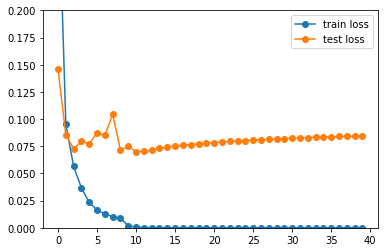

In [23]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], marker="o", label="train loss")
plt.plot(range(n_epoch), scores[:,2], marker="o", label="test loss")
plt.ylim(0, 0.2)
plt.legend()
plt.show()

In [25]:
model = MLP([Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 784, ReLU),
           Linear(784, 10, Softmax)])
n_epoch = 40
batchsize = 100
lr = 0.02

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.495, accuracy 0.8651 | Test loss 0.232, accuracy 0.9320
epoch 1 | Train loss 0.203, accuracy 0.9405 | Test loss 0.173, accuracy 0.9479
epoch 2 | Train loss 0.150, accuracy 0.9559 | Test loss 0.145, accuracy 0.9566
epoch 3 | Train loss 0.117, accuracy 0.9653 | Test loss 0.117, accuracy 0.9634
epoch 4 | Train loss 0.094, accuracy 0.9717 | Test loss 0.101, accuracy 0.9689
epoch 5 | Train loss 0.079, accuracy 0.9768 | Test loss 0.098, accuracy 0.9701
epoch 6 | Train loss 0.066, accuracy 0.9804 | Test loss 0.094, accuracy 0.9712
epoch 7 | Train loss 0.055, accuracy 0.9844 | Test loss 0.095, accuracy 0.9691
epoch 8 | Train loss 0.046, accuracy 0.9868 | Test loss 0.086, accuracy 0.9742
epoch 9 | Train loss 0.038, accuracy 0.9892 | Test loss 0.078, accuracy 0.9769
epoch 10 | Train loss 0.031, accuracy 0.9918 | Test loss 0.076, accuracy 0.9771
epoch 11 | Train loss 0.026, accuracy 0.9935 | Test loss 0.077, accuracy 0.9767
epoch 12 | Train loss 0.022, accuracy 0.9947 | Tes

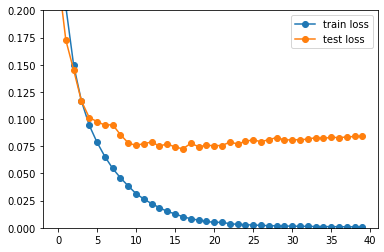

In [26]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], marker="o", label="train loss")
plt.plot(range(n_epoch), scores[:,2], marker="o", label="test loss")
plt.ylim(0, 0.2)
plt.legend()
plt.show()

#### 隠れ層をスパースにした場合

In [ ]:
%%time
# 隠れ層をスパースにする
model = MLP([Linear(784, 10000, ReLU),
             Linear(10000, 10000, ReLU),
             Linear(10000, 10, Softmax)])
n_epoch = 20
batchsize = 100
lr = 0.1

model = trial_hypparm(model, n_epoch, batchsize, lr)

# 3時間くらいかかって良くならなそうなので中止

```text
epoch 0 | Train loss 0.316, accuracy 0.9364 | Test loss 0.098, accuracy 0.9701
epoch 1 | Train loss 0.040, accuracy 0.9891 | Test loss 0.078, accuracy 0.9771
epoch 2 | Train loss 0.015, accuracy 0.9979 | Test loss 0.065, accuracy 0.9804
epoch 3 | Train loss 0.007, accuracy 0.9997 | Test loss 0.064, accuracy 0.9802
epoch 4 | Train loss 0.005, accuracy 0.9999 | Test loss 0.064, accuracy 0.9804
epoch 5 | 
(これ以上向上しそうにないので中断)
```

In [29]:
%%time
# 程々にスパース, 多層
model = MLP([Linear(784, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 10, Softmax)])

n_epoch = 40
batchsize = 100
lr = 0.02

model = trial_hypparm(model, n_epoch, batchsize, lr)
# 過学習しているので中断

epoch 0 | Train loss 0.362, accuracy 0.9123 | Test loss 0.151, accuracy 0.9547
epoch 1 | Train loss 0.100, accuracy 0.9704 | Test loss 0.114, accuracy 0.9646
epoch 2 | Train loss 0.056, accuracy 0.9840 | Test loss 0.089, accuracy 0.9715
epoch 3 | Train loss 0.032, accuracy 0.9921 | Test loss 0.085, accuracy 0.9737
epoch 4 | Train loss 0.019, accuracy 0.9968 | Test loss 0.078, accuracy 0.9747
epoch 5 | Train loss 0.011, accuracy 0.9988 | Test loss 0.078, accuracy 0.9767
epoch 6 | Train loss 0.007, accuracy 0.9997 | Test loss 0.076, accuracy 0.9766
epoch 7 | Train loss 0.005, accuracy 0.9998 | Test loss 0.077, accuracy 0.9766
epoch 8 | Train loss 0.003, accuracy 1.0000 | Test loss 0.076, accuracy 0.9772
epoch 9 | Train loss 0.003, accuracy 1.0000 | Test loss 0.077, accuracy 0.9773
epoch 10 | Train loss 0.002, accuracy 1.0000 | Test loss 0.077, accuracy 0.9776
epoch 11 | Train loss 0.002, accuracy 1.0000 | Test loss 0.077, accuracy 0.9779
epoch 12 | Train loss 0.002, accuracy 1.0000 | Tes

KeyboardInterrupt: ignored

In [30]:
import pickle
with open("relu_2000x5_0.0.2.bin", mode="wb") as f:
  pickle.dump(model, f)

#### 隠れ層を砂時計型にした場合

In [31]:
%%time
# 途中で絞ってみる
model = MLP([Linear(784, 1000, ReLU),
             Linear(1000, 100, ReLU),
             Linear(100, 1000, ReLU),
             Linear(1000, 10, Softmax)])

n_epoch = 40
batchsize = 100
lr = 0.1

model = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.376, accuracy 0.8871 | Test loss 0.172, accuracy 0.9494
epoch 1 | Train loss 0.140, accuracy 0.9581 | Test loss 0.114, accuracy 0.9654
epoch 2 | Train loss 0.096, accuracy 0.9713 | Test loss 0.099, accuracy 0.9698
epoch 3 | Train loss 0.069, accuracy 0.9792 | Test loss 0.082, accuracy 0.9741
epoch 4 | Train loss 0.052, accuracy 0.9849 | Test loss 0.073, accuracy 0.9773
epoch 5 | Train loss 0.038, accuracy 0.9889 | Test loss 0.071, accuracy 0.9796
epoch 6 | Train loss 0.029, accuracy 0.9916 | Test loss 0.068, accuracy 0.9794
epoch 7 | Train loss 0.021, accuracy 0.9940 | Test loss 0.069, accuracy 0.9799
epoch 8 | Train loss 0.016, accuracy 0.9961 | Test loss 0.064, accuracy 0.9806
epoch 9 | Train loss 0.010, accuracy 0.9982 | Test loss 0.067, accuracy 0.9807
epoch 10 | Train loss 0.008, accuracy 0.9989 | Test loss 0.065, accuracy 0.9819
epoch 11 | Train loss 0.005, accuracy 0.9994 | Test loss 0.070, accuracy 0.9810
epoch 12 | Train loss 0.004, accuracy 0.9996 | Tes

In [32]:
with open("relu_constrict.bin", mode="wb") as f:
  pickle.dump(model, f)

In [37]:
%%time
# その2
model = MLP([Linear(784, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 100, ReLU),
             Linear(100, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 10, Softmax)])
n_epoch = 40
batchsize = 100
lr = 0.02

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

with open("relu_constrict2.bin", mode="wb") as f:
  pickle.dump(model, f)

epoch 0 | Train loss 0.590, accuracy 0.8362 | Test loss 0.284, accuracy 0.9127
epoch 1 | Train loss 0.218, accuracy 0.9363 | Test loss 0.189, accuracy 0.9436
epoch 2 | Train loss 0.159, accuracy 0.9534 | Test loss 0.152, accuracy 0.9540
epoch 3 | Train loss 0.125, accuracy 0.9633 | Test loss 0.122, accuracy 0.9631
epoch 4 | Train loss 0.103, accuracy 0.9699 | Test loss 0.115, accuracy 0.9640
epoch 5 | Train loss 0.085, accuracy 0.9747 | Test loss 0.100, accuracy 0.9696
epoch 6 | Train loss 0.071, accuracy 0.9797 | Test loss 0.089, accuracy 0.9729
epoch 7 | Train loss 0.059, accuracy 0.9826 | Test loss 0.093, accuracy 0.9723
epoch 8 | Train loss 0.049, accuracy 0.9859 | Test loss 0.087, accuracy 0.9736
epoch 9 | Train loss 0.041, accuracy 0.9884 | Test loss 0.080, accuracy 0.9749
epoch 10 | Train loss 0.034, accuracy 0.9902 | Test loss 0.077, accuracy 0.9771
epoch 11 | Train loss 0.028, accuracy 0.9923 | Test loss 0.072, accuracy 0.9775
epoch 12 | Train loss 0.023, accuracy 0.9941 | Tes

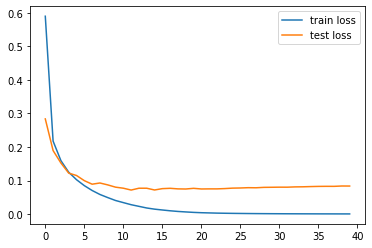

In [38]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], label="train loss")
plt.plot(range(n_epoch), scores[:,2], label="test loss")
plt.legend()
plt.show()

In [39]:
%%time
# その3
model = MLP([Linear(784, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 100, ReLU),
             Linear(100, 2000, ReLU),
             Linear(2000, 2000, ReLU),
             Linear(2000, 10, Softmax)])
n_epoch = 50
batchsize = 100
lr = 0.01

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

with open("relu_constrict3.bin", mode="wb") as f:
  pickle.dump(model, f)

epoch 0 | Train loss 0.430, accuracy 0.8776 | Test loss 0.233, accuracy 0.9313
epoch 1 | Train loss 0.185, accuracy 0.9465 | Test loss 0.159, accuracy 0.9539
epoch 2 | Train loss 0.137, accuracy 0.9599 | Test loss 0.144, accuracy 0.9574
epoch 3 | Train loss 0.107, accuracy 0.9693 | Test loss 0.115, accuracy 0.9648
epoch 4 | Train loss 0.088, accuracy 0.9742 | Test loss 0.102, accuracy 0.9701
epoch 5 | Train loss 0.073, accuracy 0.9789 | Test loss 0.095, accuracy 0.9713
epoch 6 | Train loss 0.061, accuracy 0.9823 | Test loss 0.092, accuracy 0.9721
epoch 7 | Train loss 0.051, accuracy 0.9856 | Test loss 0.090, accuracy 0.9731
epoch 8 | Train loss 0.042, accuracy 0.9885 | Test loss 0.088, accuracy 0.9741
epoch 9 | Train loss 0.036, accuracy 0.9912 | Test loss 0.086, accuracy 0.9734
epoch 10 | Train loss 0.030, accuracy 0.9928 | Test loss 0.080, accuracy 0.9764
epoch 11 | Train loss 0.025, accuracy 0.9943 | Test loss 0.080, accuracy 0.9753
epoch 12 | Train loss 0.021, accuracy 0.9959 | Tes

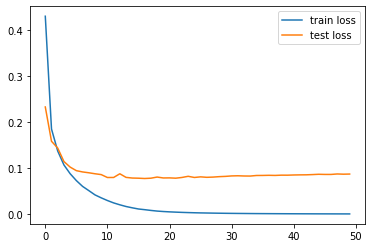

In [40]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], label="train loss")
plt.plot(range(n_epoch), scores[:,2], label="test loss")
plt.legend()
plt.show()

#### バッチサイズの大小の影響

In [20]:
# batch ÷10
model = MLP([Linear(784, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 10, Softmax)])
n_epoch = 40
batchsize = 10
lr = 0.2

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.212, accuracy 0.9357 | Test loss 0.110, accuracy 0.9684
epoch 1 | Train loss 0.096, accuracy 0.9702 | Test loss 0.121, accuracy 0.9621
epoch 2 | Train loss 0.068, accuracy 0.9791 | Test loss 0.098, accuracy 0.9736
epoch 3 | Train loss 0.053, accuracy 0.9840 | Test loss 0.072, accuracy 0.9804
epoch 4 | Train loss 0.040, accuracy 0.9876 | Test loss 0.082, accuracy 0.9770
epoch 5 | Train loss 0.033, accuracy 0.9896 | Test loss 0.069, accuracy 0.9813
epoch 6 | Train loss 0.029, accuracy 0.9915 | Test loss 0.088, accuracy 0.9796
epoch 7 | Train loss 0.023, accuracy 0.9928 | Test loss 0.123, accuracy 0.9719
epoch 8 | Train loss 0.021, accuracy 0.9935 | Test loss 0.088, accuracy 0.9795
epoch 9 | Train loss 0.021, accuracy 0.9937 | Test loss 0.095, accuracy 0.9784
epoch 10 | Train loss 0.023, accuracy 0.9932 | Test loss 0.092, accuracy 0.9822
epoch 11 | Train loss 0.019, accuracy 0.9943 | Test loss 0.102, accuracy 0.9800
epoch 12 | Train loss 0.018, accuracy 0.9948 | Tes

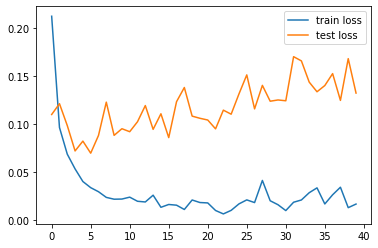

In [21]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], label="train loss")
plt.plot(range(n_epoch), scores[:,2], label="test loss")
plt.ylim(0, 0.4)
plt.legend()
plt.show()

In [22]:
with open("relu_batch10_sc.bin", mode="wb") as f:
  pickle.dump((model,scores), f)

In [23]:
# batch x10
model = MLP([Linear(784, 1000, ReLU),
             Linear(1000, 1000, ReLU),
             Linear(1000, 10, Softmax)])
n_epoch = 40
batchsize = 1000
lr = 0.2

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

with open("relu_batch1000_sc.bin", mode="wb") as f:
  pickle.dump((model,scores), f)

epoch 0 | Train loss 0.684, accuracy 0.7966 | Test loss 0.317, accuracy 0.9124
epoch 1 | Train loss 0.297, accuracy 0.9152 | Test loss 0.255, accuracy 0.9268
epoch 2 | Train loss 0.230, accuracy 0.9348 | Test loss 0.211, accuracy 0.9389
epoch 3 | Train loss 0.197, accuracy 0.9440 | Test loss 0.184, accuracy 0.9477
epoch 4 | Train loss 0.173, accuracy 0.9511 | Test loss 0.167, accuracy 0.9525
epoch 5 | Train loss 0.153, accuracy 0.9563 | Test loss 0.156, accuracy 0.9536
epoch 6 | Train loss 0.140, accuracy 0.9607 | Test loss 0.144, accuracy 0.9584
epoch 7 | Train loss 0.127, accuracy 0.9645 | Test loss 0.135, accuracy 0.9597
epoch 8 | Train loss 0.117, accuracy 0.9675 | Test loss 0.128, accuracy 0.9624
epoch 9 | Train loss 0.107, accuracy 0.9698 | Test loss 0.121, accuracy 0.9644
epoch 10 | Train loss 0.100, accuracy 0.9722 | Test loss 0.117, accuracy 0.9660
epoch 11 | Train loss 0.093, accuracy 0.9740 | Test loss 0.111, accuracy 0.9668
epoch 12 | Train loss 0.088, accuracy 0.9754 | Tes

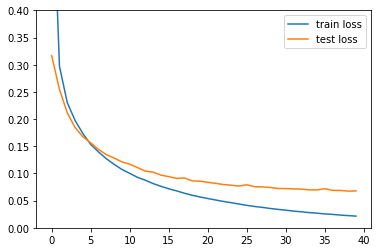

In [24]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], label="train loss")
plt.plot(range(n_epoch), scores[:,2], label="test loss")
plt.ylim(0, 0.4)
plt.legend()
plt.show()

## Dropoutによる正則化

参考：[6.4.3：Dropout【ゼロつく1のノート(実装)】―からっぽのしょこ](https://www.anarchive-beta.com/entry/2020/08/19/180000)

### 実装

In [103]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    __call__ = forward
    
    def backward(self, dout):
        return dout * self.mask

class MLP_withDropout(MLP):
    def __init__(self, layers, dropout_ratio=0):
        if 0 < dropout_ratio <= 1:
          self.layers = [layers[0]]
          for layer in layers[1:]:
            self.layers += [Dropout(dropout_ratio), layer]
        else:
          self.layers = layers
        
    def train(self, x, t, lr):   
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)
        
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        
        batchsize = len(self.layers[-1].x)
        delta = (self.y - t) / batchsize
        self.layers[-1].delta = delta
        self.layers[-1].dW = np.dot(self.layers[-1].x.T, self.layers[-1].delta)
        self.layers[-1].db = np.dot(np.ones(batchsize), self.layers[-1].delta)
        dout = np.dot(self.layers[-1].delta, self.layers[-1].W.T)
        
        self.layers[-1].W -= lr * self.layers[-1].dW # self.layers[-1].dW を用いて最終層の重みを更新しよう
        self.layers[-1].b -= lr * self.layers[-1].db # self.layers[-1].db を用いて最終層のバイアスを更新しよう
        
        for layer in self.layers[-2::-1]:
            dout = layer.backward(dout) # 逆伝播計算を順番に実行しよう
            if isinstance(layer, Dropout): 
              continue
            
            dW = layer.x.T @ layer.delta
            db = np.ones(delta.shape[0]) @ layer.delta
            layer.W -= lr * dW  # 各層の重みを更新
            layer.b -= lr * db  # 各層のバイアスを更新

        return self.loss

    def test(self, x, t):
        # 性能をテストデータで調べるために用いる
        # よって，誤差逆伝播は不要
        # 順伝播 (train関数と同様)
        self.y = x
        for layer in self.layers:
            if isinstance(layer, Dropout): 
              self.y = layer(self.y, train_flg=False)
            else:
              self.y = layer(self.y)

        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        return self.loss

### 実験

#### default

In [113]:
model = MLP_withDropout([Linear(784, 784, ReLU),
                         Linear(784, 784, ReLU),
                         Linear(784, 10, Softmax)], dropout_ratio=0.2)
n_epoch = 40
batchsize = 100
lr = 0.5

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.296, accuracy 0.9093 | Test loss 0.128, accuracy 0.9601
epoch 1 | Train loss 0.117, accuracy 0.9639 | Test loss 0.083, accuracy 0.9734
epoch 2 | Train loss 0.083, accuracy 0.9738 | Test loss 0.080, accuracy 0.9726
epoch 3 | Train loss 0.063, accuracy 0.9796 | Test loss 0.078, accuracy 0.9749
epoch 4 | Train loss 0.048, accuracy 0.9842 | Test loss 0.063, accuracy 0.9809
epoch 5 | Train loss 0.041, accuracy 0.9869 | Test loss 0.064, accuracy 0.9810
epoch 6 | Train loss 0.032, accuracy 0.9896 | Test loss 0.059, accuracy 0.9819
epoch 7 | Train loss 0.027, accuracy 0.9915 | Test loss 0.064, accuracy 0.9821
epoch 8 | Train loss 0.023, accuracy 0.9929 | Test loss 0.059, accuracy 0.9832
epoch 9 | Train loss 0.020, accuracy 0.9935 | Test loss 0.067, accuracy 0.9816
epoch 10 | Train loss 0.018, accuracy 0.9940 | Test loss 0.061, accuracy 0.9823
epoch 11 | Train loss 0.016, accuracy 0.9947 | Test loss 0.064, accuracy 0.9813
epoch 12 | Train loss 0.013, accuracy 0.9960 | Tes

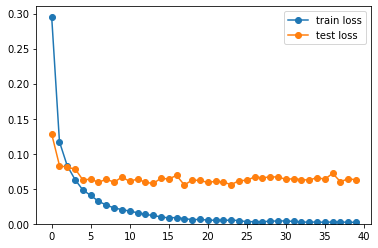

In [114]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], marker="o", label="train loss")
plt.plot(range(n_epoch), scores[:,2], marker="o", label="test loss")
plt.ylim(0, )
plt.legend()
plt.show()

In [115]:
import pickle
with open("dropout0.2_lr0.2.bin", mode="wb") as f:
  pickle.dump((model, scores), f)

#### dropout ratio の影響

In [106]:
model = MLP_withDropout([Linear(784, 1000, ReLU),
                         Linear(1000, 1000, ReLU),
                         Linear(1000, 10, Softmax)], dropout_ratio=0.1)
n_epoch = 40
batchsize = 100
lr = 0.2

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.303, accuracy 0.9089 | Test loss 0.145, accuracy 0.9561
epoch 1 | Train loss 0.127, accuracy 0.9626 | Test loss 0.104, accuracy 0.9691
epoch 2 | Train loss 0.089, accuracy 0.9725 | Test loss 0.082, accuracy 0.9755
epoch 3 | Train loss 0.068, accuracy 0.9798 | Test loss 0.081, accuracy 0.9754
epoch 4 | Train loss 0.053, accuracy 0.9844 | Test loss 0.071, accuracy 0.9779
epoch 5 | Train loss 0.043, accuracy 0.9871 | Test loss 0.063, accuracy 0.9808
epoch 6 | Train loss 0.032, accuracy 0.9904 | Test loss 0.065, accuracy 0.9797
epoch 7 | Train loss 0.026, accuracy 0.9923 | Test loss 0.067, accuracy 0.9788
epoch 8 | Train loss 0.021, accuracy 0.9943 | Test loss 0.059, accuracy 0.9822
epoch 9 | Train loss 0.018, accuracy 0.9955 | Test loss 0.056, accuracy 0.9827
epoch 10 | Train loss 0.015, accuracy 0.9962 | Test loss 0.059, accuracy 0.9817
epoch 11 | Train loss 0.013, accuracy 0.9965 | Test loss 0.060, accuracy 0.9834
epoch 12 | Train loss 0.010, accuracy 0.9976 | Tes

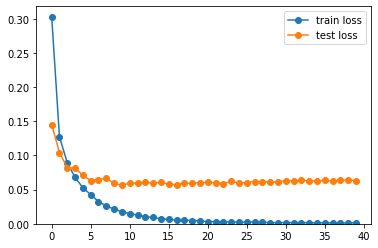

In [107]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], marker="o", label="train loss")
plt.plot(range(n_epoch), scores[:,2], marker="o", label="test loss")
plt.ylim(0, )
plt.legend()
plt.show()

In [109]:
import pickle
with open("dropout0.1_lr0.2.bin", mode="wb") as f:
  pickle.dump((model, scores), f)

In [110]:
model = MLP_withDropout([Linear(784, 1000, ReLU),
                         Linear(1000, 1000, ReLU),
                         Linear(1000, 10, Softmax)], dropout_ratio=0.4)
n_epoch = 40
batchsize = 100
lr = 0.2

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.470, accuracy 0.8631 | Test loss 0.215, accuracy 0.9356
epoch 1 | Train loss 0.216, accuracy 0.9365 | Test loss 0.144, accuracy 0.9552
epoch 2 | Train loss 0.161, accuracy 0.9521 | Test loss 0.115, accuracy 0.9654
epoch 3 | Train loss 0.130, accuracy 0.9608 | Test loss 0.098, accuracy 0.9698
epoch 4 | Train loss 0.109, accuracy 0.9667 | Test loss 0.090, accuracy 0.9724
epoch 5 | Train loss 0.094, accuracy 0.9704 | Test loss 0.081, accuracy 0.9754
epoch 6 | Train loss 0.084, accuracy 0.9748 | Test loss 0.073, accuracy 0.9772
epoch 7 | Train loss 0.074, accuracy 0.9781 | Test loss 0.069, accuracy 0.9787
epoch 8 | Train loss 0.067, accuracy 0.9786 | Test loss 0.064, accuracy 0.9799
epoch 9 | Train loss 0.061, accuracy 0.9807 | Test loss 0.063, accuracy 0.9810
epoch 10 | Train loss 0.056, accuracy 0.9823 | Test loss 0.062, accuracy 0.9801
epoch 11 | Train loss 0.050, accuracy 0.9845 | Test loss 0.062, accuracy 0.9791
epoch 12 | Train loss 0.045, accuracy 0.9860 | Tes

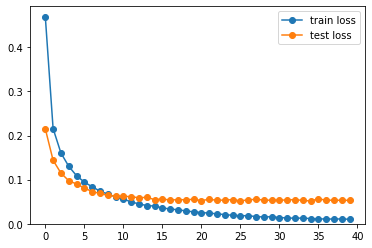

In [111]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], marker="o", label="train loss")
plt.plot(range(n_epoch), scores[:,2], marker="o", label="test loss")
plt.ylim(0, )
plt.legend()
plt.show()

In [112]:
with open("dropout0.4_lr0.2.bin", mode="wb") as f:
  pickle.dump((model, scores), f)

#### 大きいモデルで正則化

In [118]:
model = MLP_withDropout([Linear(784, 1000, ReLU),
           Linear(1000, 100, ReLU),
           Linear(100, 1000, ReLU),
           Linear(1000, 10, Softmax)], dropout_ratio=0.2)
n_epoch = 40
batchsize = 100
lr = 0.1

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.598, accuracy 0.8219 | Test loss 0.225, accuracy 0.9329
epoch 1 | Train loss 0.234, accuracy 0.9308 | Test loss 0.151, accuracy 0.9538
epoch 2 | Train loss 0.168, accuracy 0.9496 | Test loss 0.123, accuracy 0.9615
epoch 3 | Train loss 0.133, accuracy 0.9599 | Test loss 0.102, accuracy 0.9678
epoch 4 | Train loss 0.110, accuracy 0.9667 | Test loss 0.084, accuracy 0.9737
epoch 5 | Train loss 0.093, accuracy 0.9719 | Test loss 0.080, accuracy 0.9746
epoch 6 | Train loss 0.083, accuracy 0.9745 | Test loss 0.072, accuracy 0.9777
epoch 7 | Train loss 0.070, accuracy 0.9783 | Test loss 0.069, accuracy 0.9785
epoch 8 | Train loss 0.063, accuracy 0.9805 | Test loss 0.065, accuracy 0.9792
epoch 9 | Train loss 0.054, accuracy 0.9834 | Test loss 0.062, accuracy 0.9810
epoch 10 | Train loss 0.049, accuracy 0.9845 | Test loss 0.060, accuracy 0.9826
epoch 11 | Train loss 0.045, accuracy 0.9859 | Test loss 0.058, accuracy 0.9821
epoch 12 | Train loss 0.040, accuracy 0.9879 | Tes

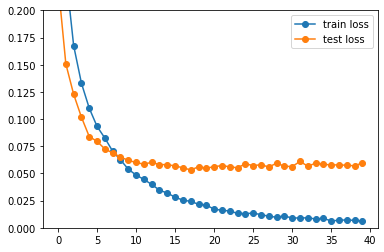

In [121]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], marker="o", label="train loss")
plt.plot(range(n_epoch), scores[:,2], marker="o", label="test loss")
plt.ylim(0, 0.2)
plt.legend()
plt.show()

In [120]:
with open("relu1000_100_1000_dropout0.2_lr0.2.bin", mode="wb") as f:
  pickle.dump((model, scores), f)

In [122]:
model = MLP_withDropout([Linear(784, 2000, ReLU),
                         Linear(2000, 2000, ReLU),
                         Linear(2000, 2000, ReLU),
                         Linear(2000, 2000, ReLU),
                         Linear(2000, 10, Softmax)], dropout_ratio=0.2)
n_epoch = 50
batchsize = 100
lr = 0.02

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.566, accuracy 0.8227 | Test loss 0.231, accuracy 0.9299
epoch 1 | Train loss 0.287, accuracy 0.9133 | Test loss 0.179, accuracy 0.9467
epoch 2 | Train loss 0.228, accuracy 0.9304 | Test loss 0.153, accuracy 0.9540
epoch 3 | Train loss 0.191, accuracy 0.9423 | Test loss 0.129, accuracy 0.9599
epoch 4 | Train loss 0.168, accuracy 0.9492 | Test loss 0.118, accuracy 0.9630
epoch 5 | Train loss 0.151, accuracy 0.9544 | Test loss 0.107, accuracy 0.9668
epoch 6 | Train loss 0.135, accuracy 0.9578 | Test loss 0.098, accuracy 0.9687
epoch 7 | Train loss 0.125, accuracy 0.9614 | Test loss 0.092, accuracy 0.9718
epoch 8 | Train loss 0.112, accuracy 0.9655 | Test loss 0.087, accuracy 0.9736
epoch 9 | Train loss 0.105, accuracy 0.9677 | Test loss 0.083, accuracy 0.9734
epoch 10 | Train loss 0.097, accuracy 0.9694 | Test loss 0.080, accuracy 0.9756
epoch 11 | Train loss 0.089, accuracy 0.9725 | Test loss 0.077, accuracy 0.9766
epoch 12 | Train loss 0.082, accuracy 0.9741 | Tes

KeyboardInterrupt: ignored

時間の都合で中断

In [124]:
with open("temp.bin", mode="rb") as f:
  model, scores = pickle.load(f)

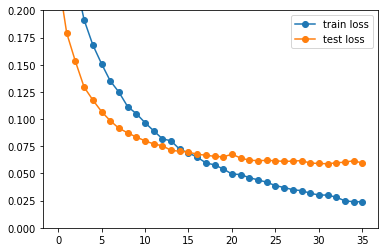

In [125]:
scores = np.array(scores)
plt.plot(range(scores.shape[0]), scores[:,0], marker="o", label="train loss")
plt.plot(range(scores.shape[0]), scores[:,2], marker="o", label="test loss")
plt.ylim(0, 0.2)
plt.legend()
plt.show()

In [126]:
with open("relu2000x4_dropout0.2_lr0.2.bin", mode="wb") as f:
  pickle.dump((model, scores), f)

## 活性化関数 Mish

参考：  
+ ついに誕生！期待の新しい活性化関数「Mish」解説―AI-SCHOLAR https://ai-scholar.tech/articles/treatise/mish-ai-374 (2021/05/17)  
+ D. Misra, "Mish: A Self Regularized Non-Monotonic Activation Function", arXiv:1908.08681  
+ 活性化関数一覧 (2020)―Qiita https://qiita.com/kuroitu/items/73cd401afd463a78115a#mish%E9%96%A2%E6%95%B0 (2021/05/17)

### 実装

In [ ]:
class Mish:
    def __init__(self):
        self.x = None
        
    def __call__(self, x):
        self.x = x
        return x * np.tanh(np.log(1+np.exp(x)))
    
    def backward(self):
        exp_x = np.exp(self.x)
        omega = 4*(self.x+1) + 4*exp_x**2 + exp_x**3 + (4*self.x+6)*exp_x
        delta = 2*exp_x + exp_x**2 + 2
        return exp_x * omega / delta**2

### 実験

In [ ]:
model = MLP([Linear(784, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 10, Softmax)])
n_epoch = 20
batchsize = 100
lr = 0.5

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.258, accuracy 0.9222 | Test loss 0.122, accuracy 0.9641
epoch 1 | Train loss 0.106, accuracy 0.9664 | Test loss 0.101, accuracy 0.9686
epoch 2 | Train loss 0.071, accuracy 0.9775 | Test loss 0.077, accuracy 0.9766
epoch 3 | Train loss 0.050, accuracy 0.9839 | Test loss 0.067, accuracy 0.9791
epoch 4 | Train loss 0.037, accuracy 0.9882 | Test loss 0.073, accuracy 0.9772
epoch 5 | Train loss 0.027, accuracy 0.9914 | Test loss 0.079, accuracy 0.9774
epoch 6 | Train loss 0.019, accuracy 0.9940 | Test loss 0.068, accuracy 0.9804
epoch 7 | Train loss 0.014, accuracy 0.9958 | Test loss 0.063, accuracy 0.9811
epoch 8 | Train loss 0.010, accuracy 0.9976 | Test loss 0.065, accuracy 0.9817
epoch 9 | Train loss 0.007, accuracy 0.9981 | Test loss 0.062, accuracy 0.9837
epoch 10 | Train loss 0.005, accuracy 0.9991 | Test loss 0.069, accuracy 0.9825
epoch 11 | Train loss 0.004, accuracy 0.9993 | Test loss 0.067, accuracy 0.9836
epoch 12 | Train loss 0.003, accuracy 0.9994 | Tes

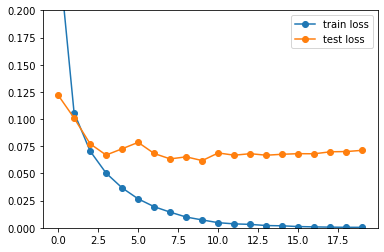

In [ ]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], marker="o", label="train loss")
plt.plot(range(n_epoch), scores[:,2], marker="o", label="test loss")
plt.ylim(0, 0.2)
plt.legend()
plt.show()

In [ ]:
# lr減, dropout導入
model = MLP_withDropout([Linear(784, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 10, Softmax)], dropout_ratio=0.2)
n_epoch = 40
batchsize = 100
lr = 0.2

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.376, accuracy 0.8909 | Test loss 0.225, accuracy 0.9354
epoch 1 | Train loss 0.198, accuracy 0.9410 | Test loss 0.155, accuracy 0.9540
epoch 2 | Train loss 0.146, accuracy 0.9569 | Test loss 0.126, accuracy 0.9619
epoch 3 | Train loss 0.120, accuracy 0.9639 | Test loss 0.108, accuracy 0.9672
epoch 4 | Train loss 0.100, accuracy 0.9703 | Test loss 0.091, accuracy 0.9719
epoch 5 | Train loss 0.086, accuracy 0.9733 | Test loss 0.088, accuracy 0.9728
epoch 6 | Train loss 0.077, accuracy 0.9764 | Test loss 0.078, accuracy 0.9752
epoch 7 | Train loss 0.067, accuracy 0.9793 | Test loss 0.073, accuracy 0.9769
epoch 8 | Train loss 0.061, accuracy 0.9807 | Test loss 0.073, accuracy 0.9773
epoch 9 | Train loss 0.056, accuracy 0.9822 | Test loss 0.073, accuracy 0.9760
epoch 10 | Train loss 0.050, accuracy 0.9843 | Test loss 0.067, accuracy 0.9786
epoch 11 | Train loss 0.046, accuracy 0.9857 | Test loss 0.065, accuracy 0.9791
epoch 12 | Train loss 0.042, accuracy 0.9870 | Tes

In [ ]:
with open("mish1000x2_dropout0.2_lr0.2.bin", mode="wb") as f:
  pickle.dump((model, scores), f)

In [ ]:
# 4層
model = MLP_withDropout([Linear(784, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 10, Softmax)], dropout_ratio=0.2)
n_epoch = 40
batchsize = 100
lr = 0.05

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.612, accuracy 0.8293 | Test loss 0.298, accuracy 0.9151
epoch 1 | Train loss 0.303, accuracy 0.9114 | Test loss 0.231, accuracy 0.9316
epoch 2 | Train loss 0.242, accuracy 0.9285 | Test loss 0.191, accuracy 0.9436
epoch 3 | Train loss 0.202, accuracy 0.9401 | Test loss 0.165, accuracy 0.9510
epoch 4 | Train loss 0.176, accuracy 0.9466 | Test loss 0.144, accuracy 0.9564
epoch 5 | Train loss 0.156, accuracy 0.9531 | Test loss 0.130, accuracy 0.9611
epoch 6 | Train loss 0.142, accuracy 0.9560 | Test loss 0.122, accuracy 0.9634
epoch 7 | Train loss 0.132, accuracy 0.9604 | Test loss 0.115, accuracy 0.9654
epoch 8 | Train loss 0.121, accuracy 0.9625 | Test loss 0.109, accuracy 0.9658
epoch 9 | Train loss 0.112, accuracy 0.9651 | Test loss 0.103, accuracy 0.9686
epoch 10 | Train loss 0.105, accuracy 0.9672 | Test loss 0.094, accuracy 0.9722
epoch 11 | Train loss 0.099, accuracy 0.9689 | Test loss 0.092, accuracy 0.9721
epoch 12 | Train loss 0.093, accuracy 0.9710 | Tes

In [ ]:
with open("mish1000x4_dropout0.2_lr0.05.bin", mode="wb") as f:
  pickle.dump((model, scores), f)

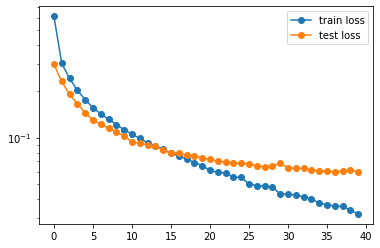

In [ ]:
scores = np.array(scores)
plt.plot(range(n_epoch), scores[:,0], marker="o", label="train loss")
plt.plot(range(n_epoch), scores[:,2], marker="o", label="test loss")
#plt.ylim()
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
# 正則化をより強く
model = MLP_withDropout([Linear(784, 1000, Mish),
             Linear(1000, 1000, Mish),
             Linear(1000, 10, Softmax)], dropout_ratio=0.4)
n_epoch = 40
batchsize = 100
lr = 0.5

model, scores = trial_hypparm(model, n_epoch, batchsize, lr)

epoch 0 | Train loss 0.368, accuracy 0.8923 | Test loss 0.188, accuracy 0.9452
epoch 1 | Train loss 0.181, accuracy 0.9452 | Test loss 0.132, accuracy 0.9586
epoch 2 | Train loss 0.135, accuracy 0.9586 | Test loss 0.103, accuracy 0.9690
epoch 3 | Train loss 0.110, accuracy 0.9654 | Test loss 0.090, accuracy 0.9721
epoch 4 | Train loss 0.093, accuracy 0.9706 | Test loss 0.077, accuracy 0.9764
epoch 5 | Train loss 0.082, accuracy 0.9734 | Test loss 0.074, accuracy 0.9778
epoch 6 | Train loss 0.071, accuracy 0.9770 | Test loss 0.070, accuracy 0.9796
epoch 7 | Train loss 0.062, accuracy 0.9801 | Test loss 0.066, accuracy 0.9806
epoch 8 | Train loss 0.056, accuracy 0.9818 | Test loss 0.067, accuracy 0.9794
epoch 9 | Train loss 0.053, accuracy 0.9825 | Test loss 0.059, accuracy 0.9813
epoch 10 | Train loss 0.045, accuracy 0.9849 | Test loss 0.060, accuracy 0.9815
epoch 11 | Train loss 0.043, accuracy 0.9858 | Test loss 0.062, accuracy 0.9814
epoch 12 | Train loss 0.039, accuracy 0.9867 | Tes

In [ ]:
with open("mish1000x2_dropout0.4_lr0.5.bin", mode="wb") as f:
  pickle.dump((model, scores), f)

In [ ]:
# 追加で学習
model, scores2 = trial_hypparm(model, 20, batchsize, lr)

epoch 0 | Train loss 0.009, accuracy 0.9970 | Test loss 0.061, accuracy 0.9850
epoch 1 | Train loss 0.008, accuracy 0.9973 | Test loss 0.062, accuracy 0.9863
epoch 2 | Train loss 0.008, accuracy 0.9971 | Test loss 0.061, accuracy 0.9864
epoch 3 | Train loss 0.007, accuracy 0.9975 | Test loss 0.065, accuracy 0.9861
epoch 4 | Train loss 0.008, accuracy 0.9973 | Test loss 0.062, accuracy 0.9866
epoch 5 | Train loss 0.008, accuracy 0.9973 | Test loss 0.062, accuracy 0.9855
epoch 6 | Train loss 0.007, accuracy 0.9977 | Test loss 0.059, accuracy 0.9865
epoch 7 | Train loss 0.007, accuracy 0.9977 | Test loss 0.061, accuracy 0.9866
epoch 8 | Train loss 0.007, accuracy 0.9976 | Test loss 0.061, accuracy 0.9861
epoch 9 | Train loss 0.007, accuracy 0.9976 | Test loss 0.063, accuracy 0.9869
epoch 10 | Train loss 0.006, accuracy 0.9981 | Test loss 0.068, accuracy 0.9857
epoch 11 | Train loss 0.006, accuracy 0.9979 | Test loss 0.063, accuracy 0.9866
epoch 12 | Train loss 0.006, accuracy 0.9981 | Tes

In [ ]:
scores = np.array(scores.tolist() + scores2)
with open("mish1000x2_dropout0.4_lr0.5_2.bin", mode="wb") as f:
  pickle.dump((model, scores), f)

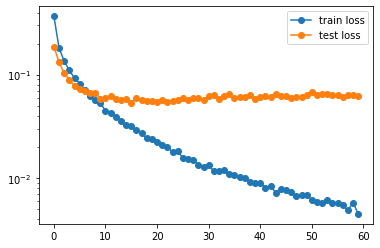

In [ ]:
plt.plot(range(60), scores[:,0], marker="o", label="train loss")
plt.plot(range(60), scores[:,2], marker="o", label="test loss")
#plt.ylim()
plt.yscale("log")
plt.legend()
plt.show()